# BERT - Out of the Box

In this notebook, we will test the performance of an out-of-the-box BERT model on CommonsenseQA. I follow the tutorial here: https://github.com/jalammar/jalammar.github.io/blob/master/notebooks/bert/A_Visual_Notebook_to_Using_BERT_for_the_First_Time.ipynb

I've implemented the Hugginface transformers library. 

I referred to the Commonsense QA repo and code to understand how the authors of this work establiahsed their baseline using BERT. This is the link to their code: https://github.com/jonathanherzig/commonsenseqa/blob/master/bert/run_commonsense_qa.py

From this repo (README): https://github.com/jonathanherzig/commonsenseqa

Their work is far more advanced and complicated than maybe what I want to do at this time. But I refer to their work to understand the set up.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

import warnings

import json
from pandas.io.json import json_normalize
warnings.filterwarnings('ignore')


from transformers import BertTokenizer, TFBertModel, BertConfig

import tensorflow as tf
from tensorflow import keras

from datetime import datetime

import time 
configuration = BertConfig() 


In [ ]:
print(tf.__version__) 

In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


In [ ]:
print("Num CPUs Available: ",
      len(tf.config.experimental.list_physical_devices('CPU')))


## Import dataset

It's in the dataset folder.

In [5]:
def load_data(file):
    lines = []
    with open(file, 'rb') as json_file:
        for json_line in json_file:
            lines.append(json.loads(json_line))
        data = json_normalize(lines)
        data.columns = data.columns.map(lambda x: x.split(".")[-1])
    return data
# os.chdir('w266-commonsenseqa/BERT_oob)
train = load_data('../dataset/train_rand_split.jsonl')
dev = load_data('../dataset/dev_rand_split.jsonl')
train.head()

,answerKey,id,question_concept,choices,stem
0,A,075e483d21c29a511267ef62bedc0461,punishing,"[{'label': 'A', 'text': 'ignore'}, {'label': '...",The sanctions against the school were a punish...
1,B,61fe6e879ff18686d7552425a36344c8,people,"[{'label': 'A', 'text': 'race track'}, {'label...",Sammy wanted to go to where the people were. ...
2,A,4c1cb0e95b99f72d55c068ba0255c54d,choker,"[{'label': 'A', 'text': 'jewelry store'}, {'la...",To locate a choker not located in a jewelry bo...
3,D,02e821a3e53cb320790950aab4489e85,highway,"[{'label': 'A', 'text': 'united states'}, {'la...",Google Maps and other highway and street GPS s...
4,C,23505889b94e880c3e89cff4ba119860,fox,"[{'label': 'A', 'text': 'pretty flowers.'}, {'...","The fox walked from the city into the forest, ..."


## Steps

1. Import training examples
2. Process it
    - Format input into something BERT can work with, including `[CLS]` and `[SEP]`
    - We were thinking which label is correct: 
    - Tokenize 
    - Create an output layer using softmax. 
3. Train it
    - Specify how many layers of BERT to fine tune
    

# BERT base model (uncased)

From: https://huggingface.co/bert-base-uncased

> Pretrained model on English language using a masked language modeling (MLM) objective. It was introduced in this paper and first released in this repository. This model is uncased: it does not make a difference between english and English.
> 
> Disclaimer: The team releasing BERT did not write a model card for this model so this model card has been written by the Hugging Face team.

In [6]:
# Use DistilBert because kernel keeps crashing 

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

For each question, there are five answer choices. Only one of them is correct.

For BERT, the first thought was to have all five answers attached to each question, and the model would choose one of the five responses. This is how it's originally done in the CommonsenseQA paper.

```
[CLS] Question text here [SEP] Ans choice A [SEP] Ans choice B [SEP] Ans choice C [SEP] Ans choice D [SEP] Ans choice E [SEP]
```

It seems complicated, however, and requires a significant lift. So for now, let me try creating five question-answer pairs for each question. Like this:

```
[CLS] Question text here [SEP] Ans choice A [SEP]
[CLS] Question text here [SEP] Ans choice B [SEP]
[CLS] Question text here [SEP] Ans choice C [SEP]
[CLS] Question text here [SEP] Ans choice D [SEP]
[CLS] Question text here [SEP] Ans choice E [SEP]
```

Only one of the above 5 inputs will have a positive label for being the correct answer. The rest will have 0. The problem with this model is that we're evaluating each choice separately to see if it looks like a right answer at all. But I think it's important for the model to know how the answer choices compare to each other as well.


In [49]:
lab_order = {"A": 0, "B":1, "C":2, "D":3, "E":4}

class InputExample(object):
    """A single multiple choice question."""
    # This class is adapted from https://github.com/jonathanherzig/commonsenseqa/blob/master/bert/run_commonsense_qa.py

    def __init__(
            self,
            qid,
            question,
            answer,
            label):
        """Construct an instance."""
        self.qid = qid
        self.question = question  # e.g., 'The sanctions against the school were a punishing blow, and they seemed to what the efforts the school had made to change?'
        self.answer = answer      # e.g., "ignore" if choice label is A 
        self.label = label        # e.g., If correct answer, 1. Otherwise 0. 
        
    def __str__(self):
        return "QUESTION: {}\nANSWER  : {}\nLABEL   : {}".format(self.question, self.answer, self.label)
    
    
def create_example(row, choice_num):
    qid = row.id
    
    # Question: Just take it from stem 
    question = row.stem
    
    # Answer choice 
    label = int(row["answerKey"] == choice_num)  # If the answer key is equal to the answer choice number, mark 1 
    answer = row["choices"][lab_order[choice_num]]["text"]         # actual ans text 
    
    return InputExample(qid, question, answer, label) 
    
    
def process_examples(data):
    examples = []
    labels = []
    questions = []
    anscands = []
    
    
    for index, row in data.iterrows(): 
        for letter in lab_order.keys():
            example = create_example(row, letter)
            examples.append(example)
            
            questions.append(example.question)
            anscands.append(example.answer)
            labels.append(example.label)
    labels = np.array(labels)
        
    encoded_example = tokenizer(questions, anscands, padding=True, truncation=True, return_tensors='tf')
    
    # Make the encoded example a dictionary of np arrays
    for key in encoded_example:
        encoded_example[key] = np.array(encoded_example[key])
        
    clean_encoded_example = [
        encoded_example["input_ids"],
        encoded_example["attention_mask"],
        encoded_example["token_type_ids"]
    ]
            
    return examples, clean_encoded_example, labels


In [50]:
tiny_train_eg, bert_inputs_train_tiny, bert_labs_train_tiny = \
process_examples(train.iloc[0:40])

In [51]:
jr_test_input_ids = np.array([tokenizer.encode('this should work'), tokenizer.encode('this should also')])
jr_test_masks = np.array([[1,1,1,1,1],[1,1,1,1,1]])
jr_test_tokens = np.array([[0,0,0,0,0],[0,0,0,0,0]])
jr_test_labels = np.array([[0], [1]])



In [42]:
print(type(bert_inputs_train_tiny[0]))
print(type(jr_test_input_ids))
print(type(bert_inputs_train_tiny[0][0]))
print(type(jr_test_input_ids[0]))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [43]:
print(type(bert_inputs_train_tiny[1]))
print(type(jr_test_masks))
print(type(bert_inputs_train_tiny[1][0]))
print(type(jr_test_masks[0]))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [45]:
print(type(bert_inputs_train_tiny[2]))
print(type(jr_test_tokens))
print(type(bert_inputs_train_tiny[2][0]))
print(type(jr_test_tokens[0]))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [52]:
print(type(bert_labs_train_tiny))
print(type(jr_test_labels))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [32]:
type(bert_inputs_train_tiny)

list

In [33]:
print(len(bert_inputs_train_tiny))
print(len(bert_inputs_train_tiny[0]))
print(len(bert_inputs_train_tiny[1]))
print(len(bert_inputs_train_tiny[2]))

3
200
200
200


**expected**

>3  
200  
200  
200

In [11]:
print(type(bert_inputs_train_tiny))
print(type(bert_inputs_train_tiny[0]))
print(type(bert_inputs_train_tiny[1]))
print(type(bert_inputs_train_tiny[2]))

<class 'list'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


**expected**

><class 'list'>  
<class 'numpy.ndarray'>  
<class 'numpy.ndarray'>  
<class 'numpy.ndarray'>

In [12]:
print(type(bert_inputs_train_tiny))
print((bert_inputs_train_tiny[0].shape))
print((bert_inputs_train_tiny[1].shape))
print((bert_inputs_train_tiny[2].shape))

<class 'list'>
(200, 36)
(200, 36)
(200, 36)


**expected**

><class 'list'>  
(200, 36)  
(200, 36)  
(200, 36)


Process dev and training data

In [13]:
dev_eg, dev_encoded_eg, dev_labs = process_examples(dev)

In [14]:
train_eg, train_encoded_eg, train_labs = process_examples(train)

In [15]:
print(dev_eg[0])

QUESTION: A revolving door is convenient for two direction travel, but it also serves as a security measure at a what?
ANSWER  : bank
LABEL   : 1


My encoded examples are all saved in `dev_encoded_eg`. Inside it I an see `input_ids`, `token_type_ids` and `attention_mask`

In [16]:
type(dev_encoded_eg)

list

In [17]:
dev_encoded_eg.keys()

AttributeError: 'list' object has no attribute 'keys'

I was a little concerned that I got a warning about no max length. But it seems like every single input has a max length with enough padding.

In [ ]:
print(tiny_train_eg[0])
print(tiny_train_eg[1])
print(tiny_train_eg[2])

In [ ]:
type(dev_encoded_eg.input_ids[0])

In [ ]:
tokenizer.decode(dev_encoded_eg.input_ids[0])

In [ ]:
dev_labs[0]

In [ ]:
print(dev_eg[1])

In [ ]:
tokenizer.tokenize("revolving")

In [ ]:
tokenizer.decode(dev_encoded_eg.input_ids[1])

**Some more notes**

* The `[CLS]` token is important. It stands for classification and it is there to represent sentence-level classification. It's added in the beginning of each sentence because the training task is sentence classification (e.g., *correct answer or incorrect answer?*)
* BERT will output a vector for each input token. Each vector is the size of *hidden_size*, which s 768 for BERT Base that we're using. For a classification task like we have at hand, we will focus on the output of just the `[CLS]` token. 

* The BERT output vector for `[CLS]` token can now be used as an input for a classifier task. We can do a simple feed-forward neural network plus softmax to see if it returns 1 or 0, or whether the answer is correct or incorrect for the question. 


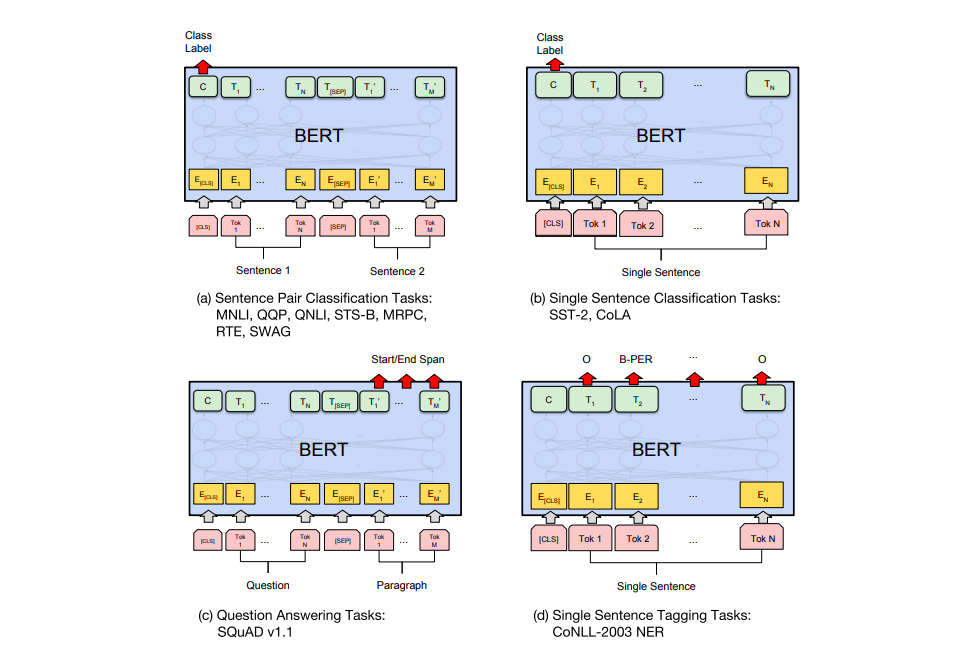

In [20]:
Image("img/bert-tasks.png") # source: http://jalammar.github.io/illustrated-bert/

For the classification, maybe what we could do is, for each question, go through the five relevant examples. Then pick the one with the highest predicted output score. Like in the "multiple choice" diagram at the bottom of this image:

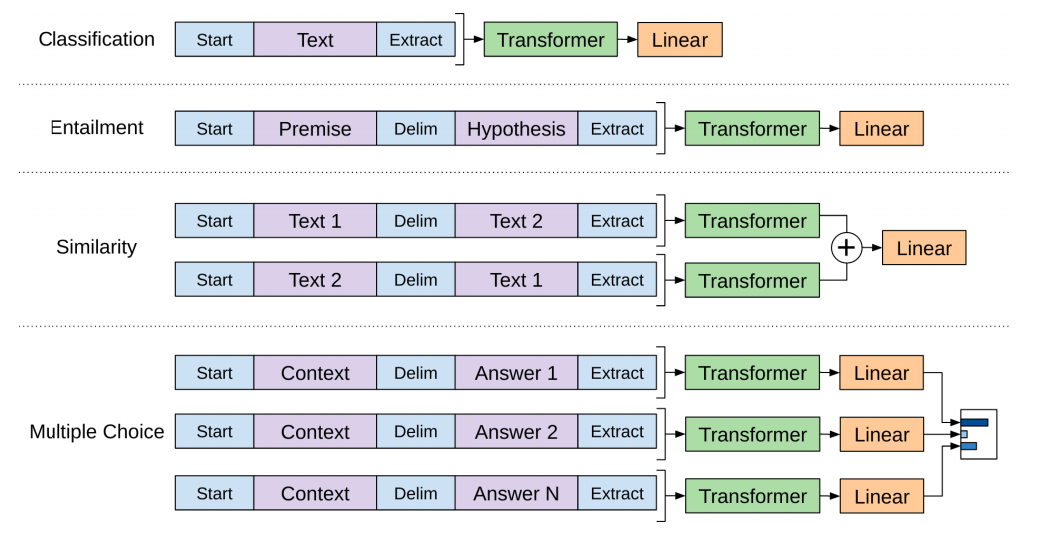

In [21]:
Image("img/openai-input transformations.png")  # source: http://jalammar.github.io/illustrated-bert/

### Game plan

I'll be following the tutorial on: http://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/, but for specifically commonsenseQA. Here are the steps from the tutorial.

1. Embed all sentences. Let's look at the output from the BERT model for our inputs. 
2. The tutorial says do a train/test split. We don't need this 'cause our data came separate.
3. Train the logistic regressio model using the training set. This is training on the output of BERT. I will need to create a FFNN to attach at the end of BERT. See what it comes back with. 
4. (Optional for now) For each question, pick the answer with the highest score. 
5. Then, evaluate against true answers. The evaluation metric will be % of questions with the correct answers out of all questions. 


#### Step 1: Embed all sentences. 

I've already formatted the CommonsenseQA inpts to be fed into the BERT model. Let's look at the output from the BERT model for our inputs. It should have a 768-long vector for each input token.

In [13]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [14]:
bert_model.summary()

Model: "tf_bert_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
Total params: 109,482,240
Trainable params: 109,482,240
Non-trainable params: 0
_________________________________________________________________


In [15]:
len(bert_inputs_train_tiny[0])

200

In [16]:
# Each example has the max num of tokens tokens. 
# Each token yields a vector of 768 numbers after coming out of the bert model!

bert_sequence = bert_model(bert_inputs_train_tiny)

In [17]:
# This task is token level masking and prediction
bert_sequence[0].shape

TensorShape([200, 36, 768])

In [23]:
# CLS token I want is here: (for example number 123)
bert_sequence[0][123, 0, :].shape

TensorShape([768])

In [18]:
# This task is, does this sentence follow the previous? Yes/no
bert_sequence[1].shape

TensorShape([200, 768])

### Sunday morning retry 

In [53]:
def classification_model(max_len):
    """Implementation of classification model.
    Returns: model"""
    ## BERT encoder
    encoder = TFBertModel.from_pretrained("bert-base-uncased")
    ## QA Model
    input_ids = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32)
    attention_mask = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32)
    token_type_ids = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32)
    embedding = encoder(
        [input_ids, attention_mask, token_type_ids]
    )[0]
    # Feed inputs through the bert model, 
    # then take just the vector associated with first token [CLS]
    bert_cls_output = embedding[:,0]
    # These are the layers that come after Bert.
    dense = tf.keras.layers.Dense(256, activation='relu', name='dense')(bert_cls_output)
    # Output layer to predict correct answer. 
    # For the future, we may modify it to choose the max candidate answer of each question
    # for now, just predict from 0 to 1 whether this looks like a correct answer. 
    pred = tf.keras.layers.Dense(1, activation='sigmoid', name='correct')(dense)
    model = tf.keras.models.Model(inputs=[input_ids, token_type_ids, attention_mask],
                                  outputs=pred)
    model.compile(loss="binary_crossentropy", 
                  optimizer="adam",
                  metrics=["accuracy"])
    model.summary()
    return model


In [ ]:
max_length= len(bert_inputs_train_tiny[0])   # num max token 
BertClassifierModel = classification_model(max_len=max_length)

In [23]:
jr_test_input_ids = np.array([tokenizer.encode('this should work'), tokenizer.encode('this should also')])
jr_test_masks = np.array([[1,1,1,1,1],[1,1,1,1,1]])
jr_test_tokens = np.array([[0,0,0,0,0],[0,0,0,0,0]])
jr_test_labels = np.array([[0], [1]])



BertClassifierModel.fit(
    [jr_test_input_ids, jr_test_masks, jr_test_tokens],
    jr_test_labels, 
    epochs=1)

1/1 [==============================] - 0s 35ms/step - loss: 0.7716 - accuracy: 0.5000


In [24]:
type(jr_test_masks)[]

numpy.ndarray

In [25]:
type(bert_inputs_train_tiny)

list

In [26]:
type(bert_inputs_train_tiny[0])

numpy.ndarray

In [27]:
type(jr_test_masks[0])

numpy.ndarray

In [28]:
type(bert_inputs_train_tiny[0][0])

numpy.ndarray

In [46]:
type(bert_labs_train_tiny)

list

In [47]:
type(bert_labs_train_tiny[0])

int

In [48]:
type(jr_test_labels)

numpy.ndarray

In [29]:
start = time.time()

BertClassifierModel.fit(
    [bert_inputs_train_tiny[0],
    bert_inputs_train_tiny[1],
    bert_inputs_train_tiny[2]],
    bert_labs_train_tiny, 
    epochs=1)
BertClassifierModel.fit(
    [bert_inputs_train_tiny[0], bert_inputs_train_tiny[1], bert_inputs_train_tiny[2]],
    jr_test_labels, 
    epochs=1)

time.time()
print("Execution duration:", end - start)

ValueError: Failed to find data adapter that can handle input: (<class 'list'> containing values of types {"<class 'numpy.ndarray'>"}), (<class 'list'> containing values of types {"<class 'int'>"})